#### The goal of this project is to beat the result of this paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf i.e. 50.76% accuracy on the food101 dataset. Possibly the result of https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment i.e. 77.4% will also be beaten ####

In [1]:
import tensorflow as tf

## Load the food101 dataset using TensorFlow Datasets ##

In [3]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             as_supervised = True,
                                             with_info = True,
                                             shuffle_files = True)

## Explore the dataset ##

In [4]:
# Get class labels
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
# Basic info about images
for image, label in train_data.take(1):
  print(f'Image shape: {image.shape}')
  print(f'Image datatype: {image.dtype}')
  print(f'Image label: {label}')
  print(f'Image class: {class_names[label]}')


Image shape: (489, 512, 3)
Image datatype: <dtype: 'uint8'>
Image label: 90
Image class: spaghetti_bolognese


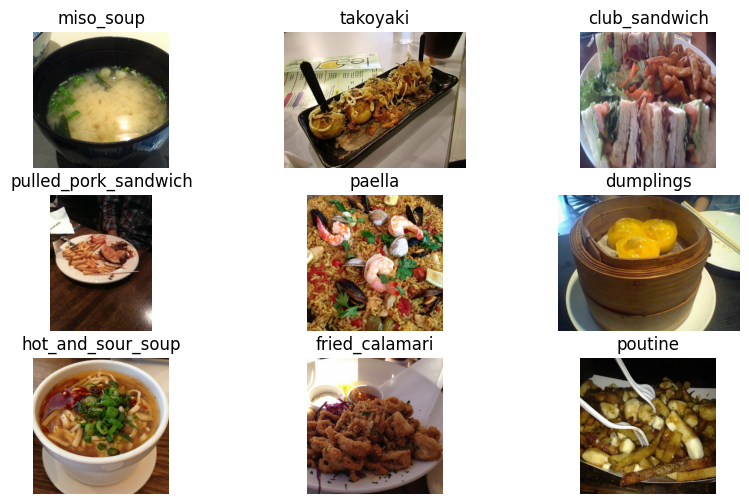

In [6]:
# Plot a couple of images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 3, ncols = 3)
fig.set_size_inches(10,6)
i, j = 0, 0
for image, label in train_data.take(9):
  if j < 3:
    ax[i][j].imshow(image)
    ax[i][j].set(title = f"{class_names[label]}")
    ax[i][j].set_axis_off()
    j+=1
  else:
    i += 1
    j = 0
    ax[i][j].imshow(image)
    ax[i][j].set(title = f"{class_names[label]}")
    ax[i][j].set_axis_off()
    j+= 1

plt.show()

## Preprocessing the data ##

In [7]:
# Dtype of images is uint8, better to cast into float32
def cast_to_float32_and_resize(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size = (224, 224))
  return tf.cast(image, tf.float32), label

# Cast and turn train and test dataset into batches (shuffle train data before turning into batches)
train_data = train_data.map(map_func = cast_to_float32_and_resize, num_parallel_calls = tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.map(map_func = cast_to_float32_and_resize, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [8]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create modeling callbacks ##

In [9]:
import datetime

checkpoint_path = "food_vision_checkpoint/cp.chpk"

# Chechpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_loss',
                                                save_best_only = True,
                                                save_weights_only = True,
                                                )

tensorboard = tf.keras.callbacks.TensorBoard(log_dir = "food_vision_tenorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## Setup mixed precision training ##

In [10]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model ##

In [12]:
base_model = tf.keras.applications.EfficientNetB7(include_top = False)
base_model.trainable = False

# input layer
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# passing data through base model
x = base_model(inputs, training = False)

# extracting feature vector
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# passing data through output layer
x = tf.keras.layers.Dense(101)(x)

# need to set-up final softmax activation manually due to mixed precision
outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32, name = 'output_layer')(x)

model = tf.keras.Model(inputs, outputs)

# compiling the model, use sparse categorical cross-entropy because labels are not hot-encoded
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


258076736/258076736 [==============================] - 1s 0us/step


## Check if mixed precision is used

In [13]:
for layer in model.layers:
  print(f'Layer name:{layer.name}, layer trainable: {layer.trainable}, layer dtype: {layer.dtype},, layer policy: {layer.dtype_policy}')

Layer name:input_layer, layer trainable: True, layer dtype: float32,, layer policy: <Policy "float32">
Layer name:efficientnetb7, layer trainable: False, layer dtype: float32,, layer policy: <Policy "mixed_float16">
Layer name:global_average_pooling2d, layer trainable: True, layer dtype: float32,, layer policy: <Policy "mixed_float16">
Layer name:dense, layer trainable: True, layer dtype: float32,, layer policy: <Policy "mixed_float16">
Layer name:output_layer, layer trainable: True, layer dtype: float32,, layer policy: <Policy "float32">


## Train the model ##

In [14]:
history_feature_extraction = model.fit(train_data,
          epochs = 3,
          validation_data = test_data,
          steps_per_epoch = len(train_data),
          validation_steps = len(test_data),
          callbacks = [checkpoint, tensorboard])

Epoch 1/3
2368/2368 [==============================] - 650s 259ms/step - loss: 1.7940 - accuracy: 0.5534 - val_loss: 1.2664 - val_accuracy: 0.6606
Epoch 2/3
2368/2368 [==============================] - 617s 259ms/step - loss: 1.3167 - accuracy: 0.6575 - val_loss: 1.1761 - val_accuracy: 0.6833
Epoch 3/3
2368/2368 [==============================] - 612s 257ms/step - loss: 1.1619 - accuracy: 0.6949 - val_loss: 1.1418 - val_accuracy: 0.6947


## Fine-tune the model (unfreeze all base model layers)

In [16]:
base_model.trainable = True

In [17]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True
block1b_activation True
block1b_se_squeeze True
block1b_se_reshape True
block1b_se_reduce True
block1b_se_expand True
block1b_se_excite True
block1b_project_conv True
block1b_project_bn True
block1b_drop True
block1b_add True
block1c_dwconv True
block1c_bn True
block1c_activation True
block1c_se_squeeze True
block1c_se_reshape True
block1c_se_reduce True
block1c_se_expand True
block1c_se_excite True
block1c_project_conv True
block1c_project_bn True
block1c_drop True
block1c_add True
block1d_dwconv True
block1d_bn True
block1d_activation True
block1d_se_squeeze True
block1d_se_reshape True
block1d_s

In [26]:
# Recompile the model and create new callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 10**(-5))

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

## Train the model

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               258661    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 64,356,348
Trainable params: 64,045,621
Non-trainable params: 310,727
___________________________________________

In [28]:
history_fine_tuning = model.fit(train_data,
          epochs = 100,
          validation_data = test_data,
          steps_per_epoch = len(train_data),
          validation_steps = len(test_data),
          initial_epoch = history_feature_extraction.epoch[-1],
          callbacks = [checkpoint, tensorboard, early_stopping, reduce_lr])

Epoch 3/100
2368/2368 [==============================] - 2065s 787ms/step - loss: 0.8859 - accuracy: 0.7601 - val_loss: 0.6537 - val_accuracy: 0.8166 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 1846s 777ms/step - loss: 0.2882 - accuracy: 0.9161 - val_loss: 0.6955 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 1791s 754ms/step - loss: 0.1199 - accuracy: 0.9622 - val_loss: 0.8021 - val_accuracy: 0.8103 - lr: 1.0000e-04
Epoch 6/100
1799/2368 [=====================>........] - ETA: 6:32 - loss: 0.0826 - accuracy: 0.9738

KeyboardInterrupt: ignored

## Evaluate the model

In [29]:
model.evaluate(test_data)

790/790 [==============================] - 151s 191ms/step - loss: 0.9395 - accuracy: 0.7999


[0.9394617676734924, 0.7998811602592468]

~80% accuracy on the test set was achieved.